# Ciência de Dados 2

## Análise exploratória - COVID IO

In [104]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
from ipywidgets import interactive
from IPython.display import clear_output 
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from matplotlib_venn import venn2, venn2_circles

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [105]:
# lê o arquivo CSV
df = pd.read_csv('datasets/covidCaseslimpo.csv', delimiter=",")

# mostra o conteúdo do DataFrame
df.head(5)

,Unnamed: 0,city,date,estimated_population,last_available_death_rate,state,new_confirmed,new_deaths
0,59,Rio Branco,2020-04-06,413418.0,0.0256,AC,1,1
1,101,Rio Branco,2020-04-13,413418.0,0.0441,AC,8,1
2,122,Rio Branco,2020-04-16,413418.0,0.0465,AC,10,1
3,136,Rio Branco,2020-04-18,413418.0,0.0446,AC,7,1
4,151,Rio Branco,2020-04-20,413418.0,0.0515,AC,13,2


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21031 entries, 0 to 21030
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21031 non-null  int64  
 1   city                       21031 non-null  object 
 2   date                       21031 non-null  object 
 3   estimated_population       21031 non-null  float64
 4   last_available_death_rate  21031 non-null  float64
 5   state                      21031 non-null  object 
 6   new_confirmed              21031 non-null  int64  
 7   new_deaths                 21031 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.3+ MB


In [107]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'city':'municipio',
                          'date':'data',
                          'estimated_population':'populacao',
                          'last_available_death_rate':'letalidade',
                          'state':'estado',
                          'new_confirmed':'confirmados',
                          'new_deaths':'obitos'}, 
                 inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21031 entries, 0 to 21030
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   municipio    21031 non-null  object 
 1   data         21031 non-null  object 
 2   populacao    21031 non-null  float64
 3   letalidade   21031 non-null  float64
 4   estado       21031 non-null  object 
 5   confirmados  21031 non-null  int64  
 6   obitos       21031 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.1+ MB


In [108]:
df["populacao"] = df["populacao"].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21031 entries, 0 to 21030
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   municipio    21031 non-null  object 
 1   data         21031 non-null  object 
 2   populacao    21031 non-null  int64  
 3   letalidade   21031 non-null  float64
 4   estado       21031 non-null  object 
 5   confirmados  21031 non-null  int64  
 6   obitos       21031 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [109]:
df.describe()

,populacao,letalidade,confirmados,obitos
count,2.103100e+04,21031.000000,21031.000000,21031.000000
mean,1.082889e+06,0.043867,214.735723,8.027150
std,1.803019e+06,0.030328,517.631168,17.182683
min,4.284000e+03,0.001700,1.000000,1.000000
25%,3.658550e+05,0.025000,40.000000,2.000000
50%,5.174510e+05,0.034800,97.000000,3.000000
75%,9.246240e+05,0.055300,224.000000,7.000000
max,1.232523e+07,1.000000,40170.000000,438.000000


In [110]:
df.groupby("municipio").size()

municipio
Alvorada         174
Ananindeua       170
Anápolis         182
Aracaju          298
Araçatuba        168
                ... 
Viamão           170
Vila Velha       285
Vitória          271
Volta Redonda    174
Várzea Grande    183
Length: 90, dtype: int64

#### Cidades com MAIS relatorios publicados de COVID

In [111]:
cidade = df.groupby(['municipio']).size().reset_index(name="Count")
cidade.sort_values('Count', ascending=False).head(5)

,municipio,Count
46,Manaus,364
65,Rio de Janeiro,364
80,São Paulo,361
10,Brasília,360
66,Salvador,349


#### Cidades com MENOS relatorios publicados de COVID

In [112]:
cidade.sort_values('Count', ascending=False).tail(5)

,municipio,Count
41,Juiz de Fora,152
67,Santarém,136
51,Niterói,132
8,Betim,128
70,Sobral,111


### Analise timeseries de confirmados X obitos

In [113]:
df['data'] = pd.to_datetime(df['data'])
covid_m = df['data'].dt.to_period("W")

dfc = df.groupby([covid_m])["confirmados", "obitos"].sum()
dfc.drop('obitos', axis=1, inplace=True)

dfd = df.groupby([covid_m])["confirmados", "obitos"].sum()
dfd.drop('confirmados', axis=1, inplace=True)

In [114]:
dfc["confirmados"].sum()

4516107

In [115]:
dfd["obitos"].sum()

168819

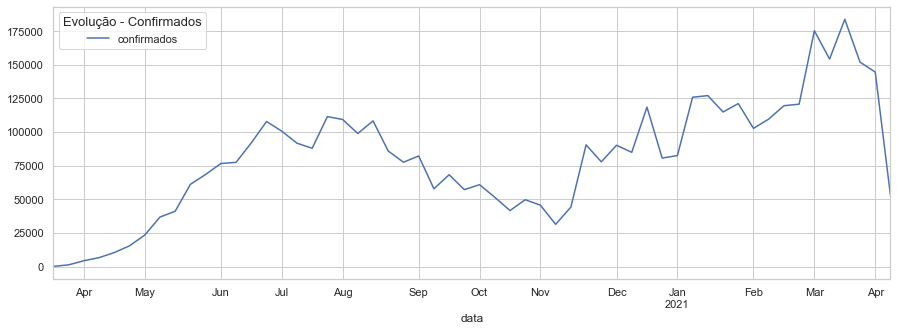

In [116]:
dfc.plot(figsize=(15,5)).legend(title="Evolução - Confirmados", fontsize=11, title_fontsize=13)

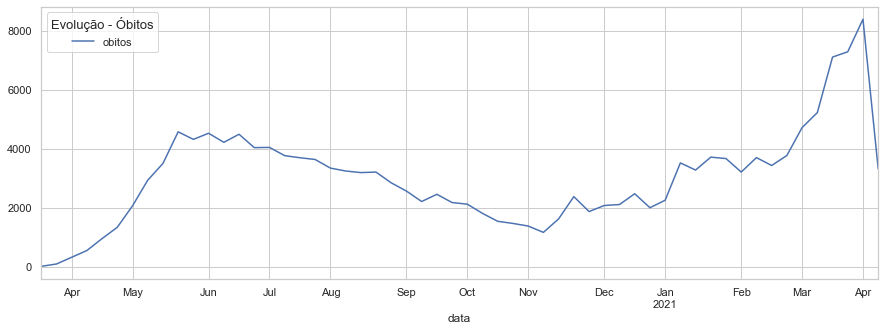

In [117]:
dfd.plot(figsize=(15,5)).legend(title="Evolução - Óbitos", fontsize=11, title_fontsize=13)

### Analise de Confirmados x Obitos por estados

### Muitos estados dificultam a visualização por isso vamos filtrar somente os que possuem mais municipios entre a lista total por numero de óbitos acumulados

Text(0.5, 1.0, 'Numero de Municipios por estado')

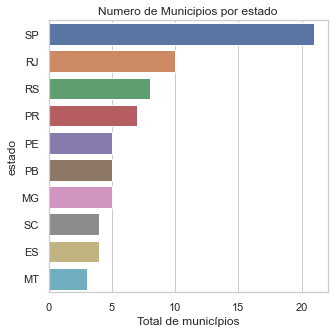

In [118]:
df_cidades = df.groupby(['estado', 'municipio']).size().reset_index(name="Count")
df_cidades.drop('Count', axis=1, inplace=True)

df_cidades = df_cidades.groupby(['estado']).size().reset_index(name="Count")

f, ax = plt.subplots(figsize=(5,5))
ax = sns.barplot(x="Count", y="estado", order=df_cidades.sort_values('Count', ascending=False)["estado"].head(10), data=df_cidades, orient='h')
plt.xlabel("Total de municípios")
plt.title("Numero de Municipios por estado")
# valor dentro da barra

### Percebemos que os estados de SP, RJ, RS estão liderando. Em parte podemos atribuir isso a população desses estados porém se observarmos os outros estados com uma população grande não possuem tantos municipios na lista

### Estados que não estão na lista com mais municipios porem aparecem com maior população: BA, DF, e PA

In [119]:
df_cidades_pop = df.groupby(['estado', 'municipio', 'populacao']).size().reset_index(name="Count")
df_cidades_pop.drop('Count', axis=1, inplace=True)


df_cidades_pop = df_cidades_pop.groupby(['estado'])['populacao'].sum().reset_index(name="populacao")
df_cidades_pop.sort_values('populacao', ascending=False).head(10)

,estado,populacao
25,SP,23358499
18,RJ,11910078
10,MG,4519776
17,PR,4229135
22,RS,3695349
15,PE,3453097
4,BA,3100383
6,DF,3055149
5,CE,2969555
13,PA,2341668


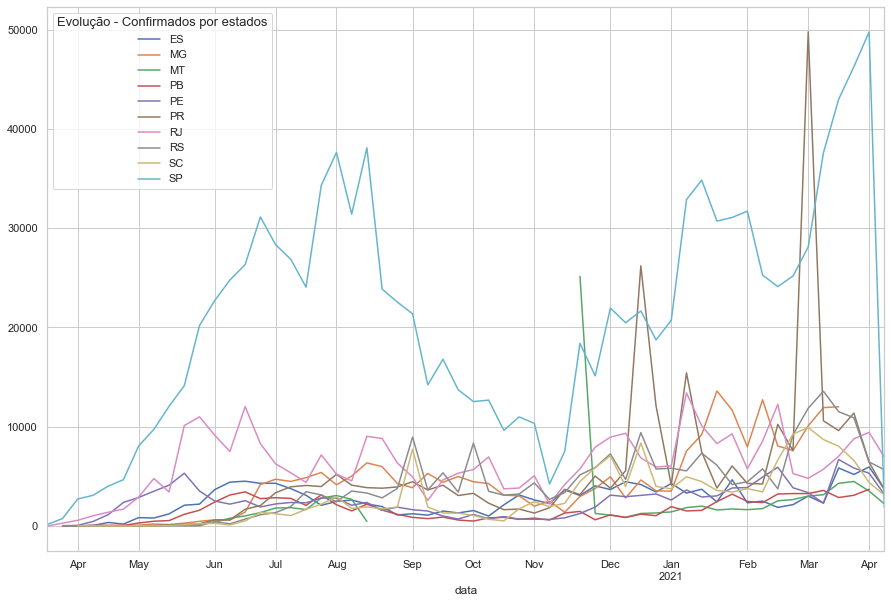

In [120]:
list_estados = df_cidades.sort_values('Count', ascending=False)["estado"].head(10).reset_index()["estado"]

covid_m = df['data'].dt.to_period("W")

df_estado = df.groupby([covid_m,'estado'])["confirmados", "obitos"].sum().reset_index()
df_estado.drop('obitos', axis=1, inplace=True)

df_estado = df_estado[df_estado['estado'].isin(list_estados)]
df_estado.pivot(index="data", columns="estado", values="confirmados").plot(figsize=(15,10)).legend(title="Evolução - Confirmados por estados", fontsize=11, title_fontsize=13)

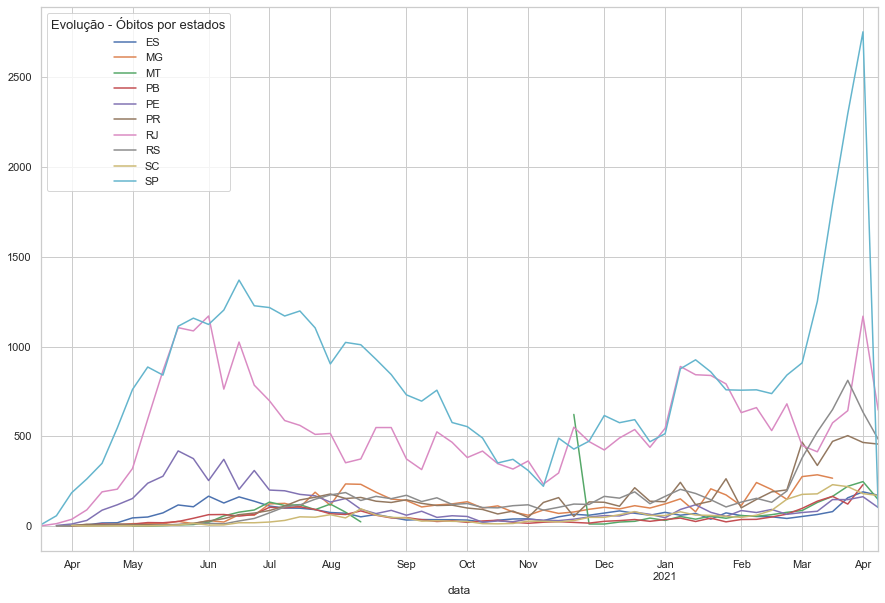

In [121]:
list_estados = df_cidades.sort_values('Count', ascending=False)["estado"].head(10).reset_index()["estado"]

covid_m = df['data'].dt.to_period("W")

df_estado = df.groupby([covid_m,'estado'])["confirmados", "obitos"].sum().reset_index()
df_estado.drop('confirmados', axis=1, inplace=True)

df_estado = df_estado[df_estado['estado'].isin(list_estados)]
df_estado.pivot(index="data", columns="estado", values="obitos").plot(figsize=(15,10)).legend(title="Evolução - Óbitos por estados", fontsize=11, title_fontsize=13)

### Baseado nos dados acima decidimos continuar analisando esse ranking de 5 estados por eles possuirem mais municipios nas top 100 cidades com numero de obitos. 

##### fonte: http://covid19.io/ - Acesso em 10/04/2021 - Ranking 100 cidades por numero de obitos acumulados

## Análise de letalidade

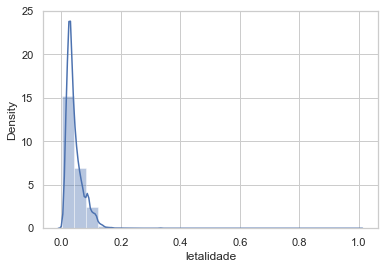

In [122]:
sns.distplot(df['letalidade'], bins=25);

In [123]:
df_dr = df[df['letalidade'] >= 0.2]
df_dr

,municipio,data,populacao,letalidade,estado,confirmados,obitos
288,Campo Grande,2020-05-15,9567,0.2000,AL,1,1
298,Belém,2020-05-24,4284,0.5000,AL,1,1
1825,Cascavel,2020-04-16,72232,0.3333,CE,2,1
6219,Santarém,2020-04-01,306480,1.0000,PA,1,1
7423,Olinda,2020-04-05,393115,0.3333,PE,1,2
7429,Olinda,2020-04-08,393115,0.2381,PE,3,2
9001,Maringá,2020-03-27,430157,0.2857,PR,4,2
10435,Petrópolis,2020-03-21,306678,0.3333,RJ,3,1
10449,Duque de Caxias,2020-04-04,924624,0.2308,RJ,4,3
10459,Duque de Caxias,2020-04-08,924624,0.2105,RJ,5,3


In [124]:
df_dr.describe(include="all")

,municipio,data,populacao,letalidade,estado,confirmados,obitos
count,26,26,2.600000e+01,26.000000,26,26.000000,26.000000
unique,16,21,NaN,NaN,8,NaN,NaN
top,Duque de Caxias,2020-03-25 00:00:00,NaN,NaN,RJ,NaN,NaN
freq,8,3,NaN,NaN,10,NaN,NaN
first,NaN,2020-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-24 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.999534e+05,0.359404,NaN,6.692308,2.884615
std,NaN,NaN,3.501168e+05,0.249940,NaN,8.961113,4.003268
min,NaN,NaN,4.284000e+03,0.200000,NaN,1.000000,1.000000
25%,NaN,NaN,3.220972e+05,0.213175,NaN,1.000000,1.000000


In [125]:
df_dr['data'].min()

Timestamp('2020-03-21 00:00:00')

In [126]:
df_dr['data'].max()

Timestamp('2020-05-24 00:00:00')

### Na maior parte dos casos onde o death rate e muito grande foi na fase inicial da pandemia e tambem em casos onde foram confirmados um numero pequeno de pessoas

### Verificando o o death rate por estados 

In [127]:
df_dr = df.groupby(['estado'])["letalidade"].sum().reset_index()
df_l = df.groupby(['estado']).size().reset_index(name="Count")

df_dr['letalidade'] = df_dr['letalidade'] / df_l["Count"]
df_dr.head()

,estado,letalidade
0,AC,0.032140
1,AL,0.037020
2,AM,0.056046
3,AP,0.024800
4,BA,0.027877


Text(0.5, 1.0, 'Taxa de letalidade %')

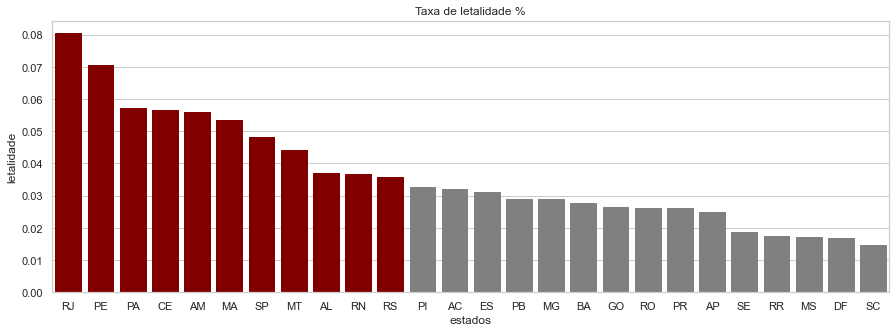

In [128]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x="estado", y="letalidade", order=df_dr.sort_values('letalidade', ascending=False)["estado"], data=df_dr)

for bar in ax.patches:
    if bar.get_height() > 0.033:
        bar.set_color('#800000')    
    else:
        bar.set_color('grey')
        
plt.xlabel("estados")
plt.title("Taxa de letalidade %")
# valor dentro da barra

### Taxa de letalidade mundial fica em torno de 3,3%. Em destque vemso os estados com uma taxa de letalidade acima de 3.3%. 


#### fonte: https://portal.fiocruz.br/noticia/letalidade-por-covid-19-no-rio-esta-acima-da-media-mundial

## Análise exploratória - Twitter 

In [129]:
# lê o arquivo CSV
df_twitter = pd.read_csv('datasets/PrefsTweetsLimpoStemmerSB.csv', delimiter=",")

df_twitter['final_tokens']=df_twitter['final_tokens'].str[1:-1].str.split(',').tolist()
df_twitter['tokens']=df_twitter['tokens'].str[1:-1].str.split(',').tolist()

# mostra o conteúdo do DataFrame
df_twitter.head(5)

,Unnamed: 0,municipio,tweet_id,created_at,text,tokens,referenced_twitter,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count,tokens_frase,final_tokens
0,0,São Paulo,1380999403910094855,2021-04-10,Esse da foto e o Pluto um filhote calminho e s...,"['foto', 'pluto', 'filhote', 'calminho', '...",False,4,0,9,0,foto pluto filhote calminho super brincalhao i...,"['fot', 'plut', 'filhot', 'calminh', 'sup'..."
1,1,São Paulo,1380985859059576832,2021-04-10,O inicio da vacinacao dos idosos com anos ou ...,"['inicio', 'vacinacao', 'idosos', 'anos', ...",False,0,1,1,0,inicio vacinacao idosos anos antecipado segund...,"['inici', 'vacinaca', 'idos', 'anos', 'ant..."
2,2,São Paulo,1380969544513159176,2021-04-10,RT spsmdet Uma onda de solidariedade chegou ao...,"['rt', 'spsmdet', 'onda', 'solidariedade', ...",True,2,0,0,0,rt spsmdet onda solidariedade chegou banco ali...,"['rt', 'spsmdet', 'onda', 'solidariedad', ..."
3,3,São Paulo,1380960415555915781,2021-04-10,A Secretaria de Educacao divulgou a convocacao...,"['secretaria', 'educacao', 'divulgou', 'con...",False,0,0,2,0,secretaria educacao divulgou convocacao candid...,"['secret', 'educaca', 'divulg', 'convocaca'..."
4,4,São Paulo,1380953886299713541,2021-04-10,Os postos drivethru que fazem parte da estrutu...,"['postos', 'drivethru', 'fazem', 'parte', ...",False,1,0,3,0,postos drivethru fazem parte estrutura campanh...,"['post', 'drivethru', 'faz', 'part', 'estr..."


In [130]:
df_twitter.drop('Unnamed: 0', axis=1, inplace=True)
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71273 entries, 0 to 71272
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   municipio                     71273 non-null  object
 1   tweet_id                      71273 non-null  int64 
 2   created_at                    71273 non-null  object
 3   text                          71273 non-null  object
 4   tokens                        71273 non-null  object
 5   referenced_twitter            71273 non-null  bool  
 6   public_metrics_retweet_count  71273 non-null  int64 
 7   public_metrics_reply_count    71273 non-null  int64 
 8   public_metrics_like_count     71273 non-null  int64 
 9   public_metrics_quote_count    71273 non-null  int64 
 10  tokens_frase                  70385 non-null  object
 11  final_tokens                  71273 non-null  object
dtypes: bool(1), int64(5), object(6)
memory usage: 6.0+ MB


In [131]:
df_twitter.describe()

,tweet_id,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count
count,7.127300e+04,71273.000000,71273.000000,71273.000000,71273.000000
mean,1.325370e+18,3.126906,1.300941,11.704853,0.553141
std,4.712606e+16,81.579676,6.425381,112.825869,13.521296
min,1.232098e+18,0.000000,0.000000,0.000000,0.000000
25%,1.279431e+18,0.000000,0.000000,1.000000,0.000000
50%,1.345097e+18,0.000000,0.000000,3.000000,0.000000
75%,1.365297e+18,1.000000,1.000000,8.000000,0.000000
max,1.381087e+18,14667.000000,736.000000,13584.000000,1978.000000


In [132]:
df_twitter[df_twitter.isna().any(axis=1)]

,municipio,tweet_id,created_at,text,tokens,referenced_twitter,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count,tokens_frase,final_tokens
1143,São Paulo,1361021108552691714,2021-02-14,httpstcodFCjY9GSRS,[],False,0,1,6,0,NaN,[]
1152,São Paulo,1360980103707189256,2021-02-14,httpstcoq5RnJZ1m9L,[],False,0,1,4,0,NaN,[]
1413,São Paulo,1355644723411693577,2021-01-30,httpstco4LBPcYffj4,[],False,0,3,3,0,NaN,[]
2157,São Paulo,1340796977186025472,2020-12-20,httpstcog4Sqxo1Tyg,[],True,0,0,1,0,NaN,[]
2160,São Paulo,1340751376352198658,2020-12-20,httpstcoQfKAZckWiX httpstcoZZOzVYPOhH,[],True,0,0,1,0,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
69937,Chapecó,1370003506493542400,2021-03-11,httpstcoBVD99JQRdq httpstcoI7w8BGxjkJ,[],False,0,1,1,0,NaN,[]
69942,Chapecó,1368973710602960899,2021-03-08,httpstcowq7zAwabUV,[],False,0,0,2,0,NaN,[]
69949,Chapecó,1366085375937150980,2021-02-28,httpstcoej4UiUNbLT,[],False,0,2,9,1,NaN,[]
69969,Chapecó,1364315685820760073,2021-02-23,httpstcoAO6eCqm8sE,[],False,2,0,12,1,NaN,[]


In [133]:
df_twitter = df_twitter.dropna()
df_twitter.describe()

,tweet_id,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count,public_metrics_quote_count
count,7.038500e+04,70385.000000,70385.000000,70385.000000,70385.000000
mean,1.325476e+18,3.143482,1.300618,11.646970,0.535213
std,4.707454e+16,82.058729,6.394361,111.640343,12.290238
min,1.232098e+18,0.000000,0.000000,0.000000,0.000000
25%,1.279755e+18,0.000000,0.000000,1.000000,0.000000
50%,1.345104e+18,0.000000,0.000000,3.000000,0.000000
75%,1.365303e+18,1.000000,1.000000,8.000000,0.000000
max,1.381087e+18,14667.000000,736.000000,13584.000000,1978.000000


### Conforme mencionado anteriormente vamos utilizar a lista de estados com a  maior parte dos municipios no ranking de cidades com mais obitos acumulados 

In [134]:
list_estados = df_cidades.sort_values('Count', ascending=False)["estado"].reset_index()["estado"].head(10)
list_estados

0    SP
1    RJ
2    RS
3    PR
4    PE
5    PB
6    MG
7    SC
8    ES
9    MT
Name: estado, dtype: object

In [135]:
# lê o arquivo CSV
df_estados_merge = pd.read_csv('datasets/TwitterPrefeiturasCOVIDIO.csv', delimiter=";")

## Adicionado o estado no df do twitter tambem. 
df_merge_tt = pd.merge(df_twitter, df_estados_merge, left_on='municipio', right_on='Municipio')

df_merge_tt.drop('Data', axis=1, inplace=True)
df_merge_tt.drop('Municipio', axis=1, inplace=True)
df_merge_tt.drop('Confirmados', axis=1, inplace=True)
df_merge_tt.drop('Confirmados 100k habitantes', axis=1, inplace=True)
df_merge_tt.drop('Obitos', axis=1, inplace=True)
df_merge_tt.drop('Letalidade', axis=1, inplace=True)
df_merge_tt.drop('Obitos 100k habitantes', axis=1, inplace=True)
df_merge_tt.drop('perfil', axis=1, inplace=True)
df_merge_tt.drop('tweet_id', axis=1, inplace=True)

df_merge_tt.rename(columns={'UF':'estado',
                          'public_metrics_reply_count':'reply_count',
                          'public_metrics_retweet_count':'retweet_count',
                          'public_metrics_like_count':'like_count',
                          'public_metrics_quote_count':'quote_count'}, 
                 inplace=True)

df_merge_tt = df_merge_tt[['estado', 'municipio','created_at', 'text', 'tokens', 'tokens_frase', 'final_tokens', 'referenced_twitter', 'retweet_count', 'reply_count','like_count','quote_count' ]]
df_merge_tt['created_at'] = pd.to_datetime(df_merge_tt['created_at'])

df_merge_tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70385 entries, 0 to 70384
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   estado              70385 non-null  object        
 1   municipio           70385 non-null  object        
 2   created_at          70385 non-null  datetime64[ns]
 3   text                70385 non-null  object        
 4   tokens              70385 non-null  object        
 5   tokens_frase        70385 non-null  object        
 6   final_tokens        70385 non-null  object        
 7   referenced_twitter  70385 non-null  bool          
 8   retweet_count       70385 non-null  int64         
 9   reply_count         70385 non-null  int64         
 10  like_count          70385 non-null  int64         
 11  quote_count         70385 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(6)
memory usage: 6.5+ MB


In [136]:
df_merge_tt = df_merge_tt[df_merge_tt['estado'].isin(list_estados)]
df_merge_tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46641 entries, 0 to 70384
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   estado              46641 non-null  object        
 1   municipio           46641 non-null  object        
 2   created_at          46641 non-null  datetime64[ns]
 3   text                46641 non-null  object        
 4   tokens              46641 non-null  object        
 5   tokens_frase        46641 non-null  object        
 6   final_tokens        46641 non-null  object        
 7   referenced_twitter  46641 non-null  bool          
 8   retweet_count       46641 non-null  int64         
 9   reply_count         46641 non-null  int64         
 10  like_count          46641 non-null  int64         
 11  quote_count         46641 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(6)
memory usage: 4.3+ MB


### Analisando a distribuição do tamanho dos tweets

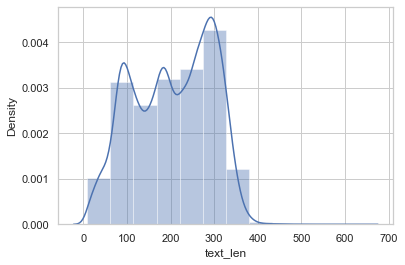

In [137]:
df_merge_tt['text_len'] = df_merge_tt['final_tokens'].astype(str).apply(len)
sns.distplot(df_merge_tt['text_len'], bins=12);

<AxesSubplot:xlabel='created_at'>

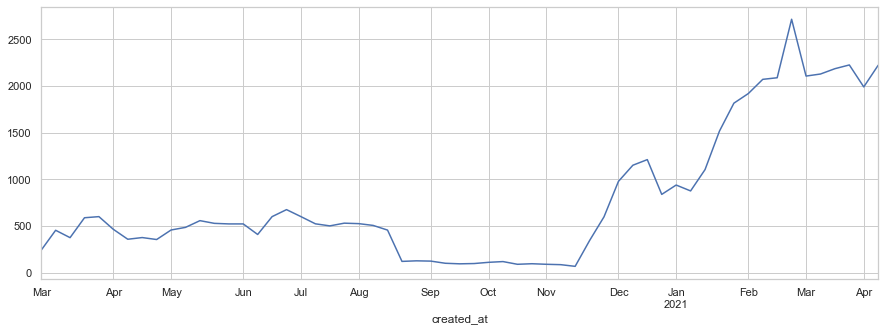

In [138]:
covid_m_t = df_merge_tt['created_at'].dt.to_period("W")

dfcx = df_merge_tt.groupby([covid_m_t]).size()

dfcx.plot(figsize=(15,5))

### Analisando a quantidade de tweets por cidade e estados

Text(0.5, 1.0, 'Ranking de total de tweets por municipio')

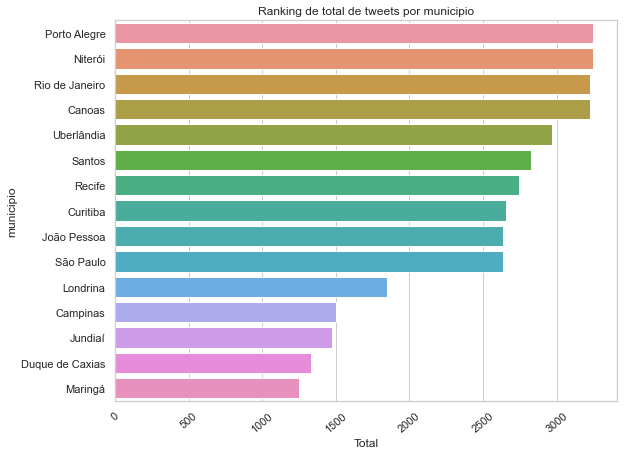

In [139]:
df_municipio = df_merge_tt.groupby(['municipio']).size().reset_index(name="Count")

f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="Count", y="municipio", order=df_municipio.sort_values('Count', ascending=False)["municipio"].head(15), data=df_municipio, orient='h')
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.title("Ranking de total de tweets por municipio")

Text(0.5, 1.0, 'Ranking com prefeituras que menos tem tweets')

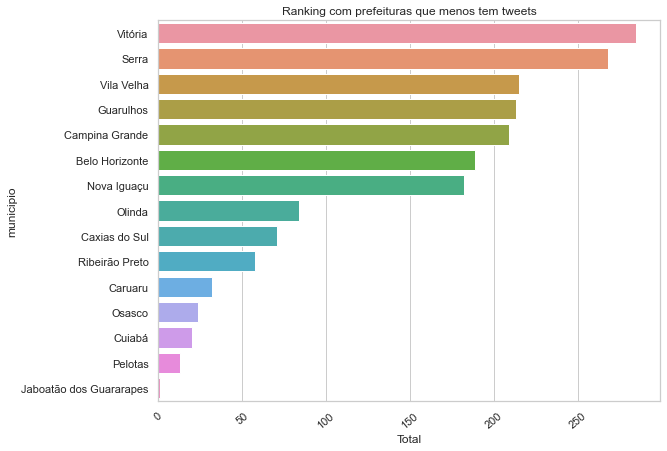

In [140]:
df_municipio = df_merge_tt.groupby(['municipio']).size().reset_index(name="Count")

f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="Count", y="municipio", order=df_municipio.sort_values('Count', ascending=False)["municipio"].tail(15), data=df_municipio, orient='h')
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.title("Ranking com prefeituras que menos tem tweets")

Text(0.5, 1.0, 'Quantidade de tweets por estado')

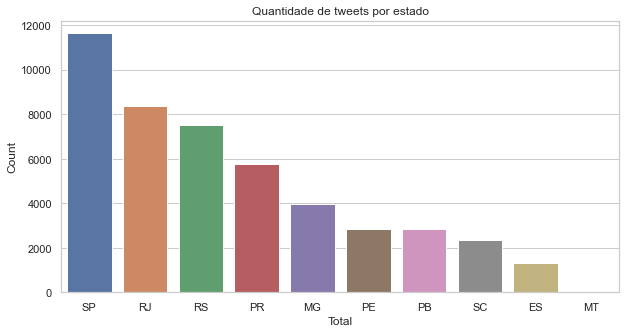

In [141]:
df_est = df_merge_tt.groupby('estado').size().reset_index(name="Count")

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="estado", y="Count", order=df_est.sort_values('Count', ascending=False)["estado"], data=df_est)
plt.xlabel("Total")
plt.title("Quantidade de tweets por estado")

### Como esperado temos um maior distribuição em tweets de 100 a 350 caracteres. Nosso proximo passo vamos pegar somente os tweets relacionados a pandemia.

##### fonte da lista de termos: https://www.sciencedirect.com/science/article/pii/S2352340920310738
##### Data Article: A first public dataset from Brazilian twitter and news on COVID-19 in Portuguese

In [142]:
list_covid_terms = ["covid", 'vacinaca', "covid19", "vacin", "coron", "coronavirus","pandem", "quarenten", "cloroquin", "hidroxicloroquin", "azitromicin", "masc", "lockdown", "comorb"]

def check_covid_terms(tokens):  
    covid_term = 0;
    
    for word in tokens:
        covid_term = [True for match in list_covid_terms if match in word]
        if True in covid_term:
            covid_term = 1
            break;
    
    return covid_term

df_merge_tt['covid_terms'] = df_merge_tt['final_tokens'].apply(lambda x: check_covid_terms(x))
df_twitter_covid = df_merge_tt[df_merge_tt['covid_terms'] == 1]
df_twitter_covid.head()

,estado,municipio,created_at,text,tokens,tokens_frase,final_tokens,referenced_twitter,retweet_count,reply_count,like_count,quote_count,text_len,covid_terms
1,SP,São Paulo,2021-04-10,O inicio da vacinacao dos idosos com anos ou ...,"['inicio', 'vacinacao', 'idosos', 'anos', ...",inicio vacinacao idosos anos antecipado segund...,"['inici', 'vacinaca', 'idos', 'anos', 'ant...",False,0,1,1,0,268,1
4,SP,São Paulo,2021-04-10,Os postos drivethru que fazem parte da estrutu...,"['postos', 'drivethru', 'fazem', 'parte', ...",postos drivethru fazem parte estrutura campanh...,"['post', 'drivethru', 'faz', 'part', 'estr...",False,1,0,3,0,277,1
10,SP,São Paulo,2021-04-10,Caso tenha algum sintoma busque a UBS mais per...,"['caso', 'algum', 'sintoma', 'busque', 'ub...",caso algum sintoma busque ubs perto voce atrav...,"['cas', 'algum', 'sintom', 'busqu', 'ubs',...",True,0,0,3,0,246,1
11,SP,São Paulo,2021-04-10,A Covid19 tem tirado a vida de milhares de pes...,"['covid19', 'tirado', 'vida', 'milhares', ...",covid19 tirado vida milhares pessoas inclusive...,"['covid19', 'tir', 'vid', 'milh', 'pesso',...",False,2,3,5,0,304,1
14,SP,São Paulo,2021-04-10,RT saudeprefsp Na tercafeira a capital inici...,"['rt', 'saudeprefsp', 'tercafeira', 'capita...",rt saudeprefsp tercafeira capital iniciara vac...,"['rt', 'saudeprefsp', 'tercafeir', 'capital...",True,4,0,0,0,165,1


<AxesSubplot:xlabel='created_at'>

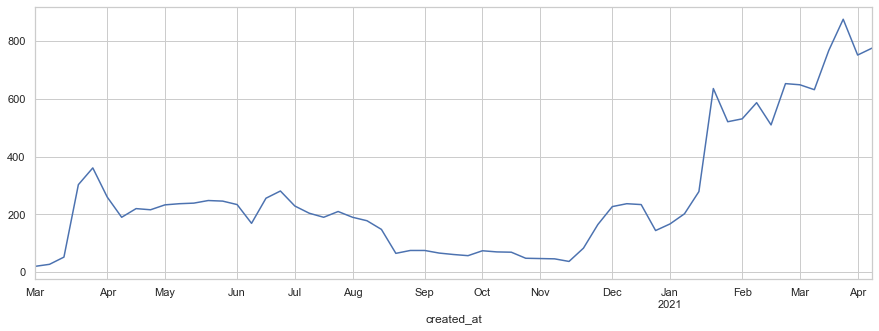

In [143]:
covid_m_t = df_twitter_covid['created_at'].dt.to_period("W")

dfcx = df_twitter_covid.groupby([covid_m_t]).size()

dfcx.plot(figsize=(15,5))

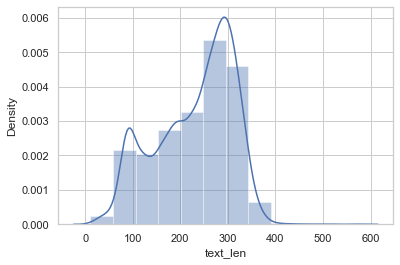

In [144]:
sns.distplot(df_twitter_covid['text_len'], bins=12);

In [145]:
# Agrupamentos e união dos textos por estado
df_estados = df_twitter_covid.groupby('estado')['tokens_frase'].apply(lambda x: ' '.join(x))

# Mostrando o conteúdo de todos os municipios do estado de Sao Paulo
df_estados['SP']

'inicio vacinacao idosos anos antecipado segunda estimativa pessoas nessa faixa etaria recebam primeira dose toda estrutura vacinacao estara aberta totalizando postos saiba postos drivethru fazem parte estrutura campanha vacinacao contra covid19 cidade sao paulo estarao abertos neste sabado h h vacinar profissionais educacao anos confira caso algum sintoma busque ubs perto voce atraves ferramenta busca saude plataforma esaude contem informacoes sobre covid19 ate telemedicina saiba covid19 tirado vida milhares pessoas inclusive jovens baseado nisso nova campanha covid19 mata nao importa idade busca incentivar populacao evitar aglomeracao usar mascara higienizar maos rt saudeprefsp tercafeira capital iniciara vacinacao idosos anos caso faca parte grupo va ate rt cetsp durante pandemia covid19 saia casa apenas necessario precisar sair lembrese sempre usar mascara el vacinacao contra covid19 segue pauta nesta semana inclusao novo grupo prioritario marca milhoes doses aplicadas atingida ale

Estado ES 


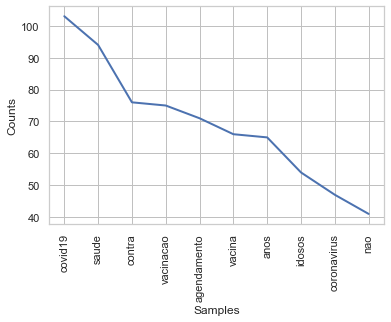

Estado MG 


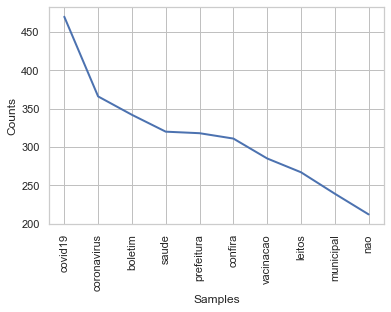

Estado MT 


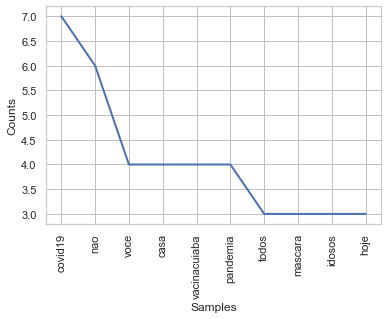

Estado PB 


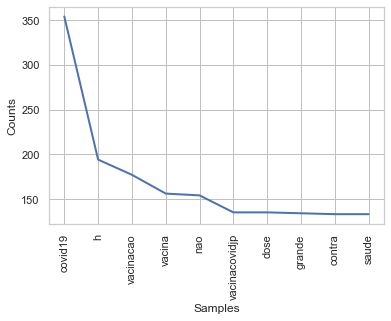

Estado PE 


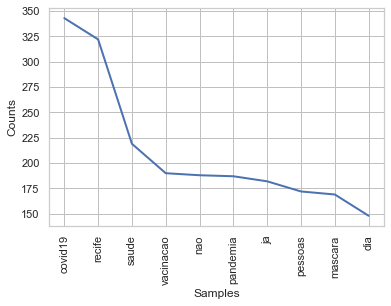

Estado PR 


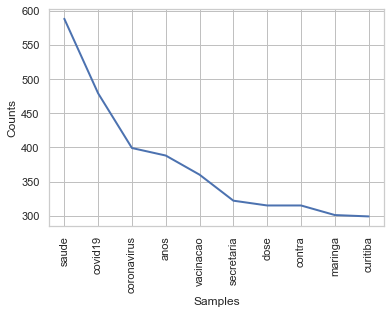

Estado RJ 


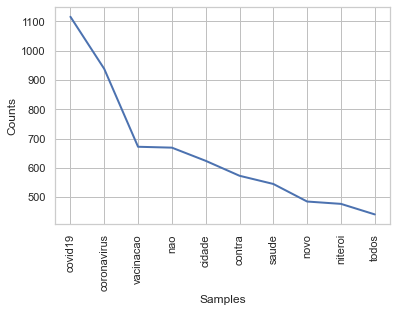

Estado RS 


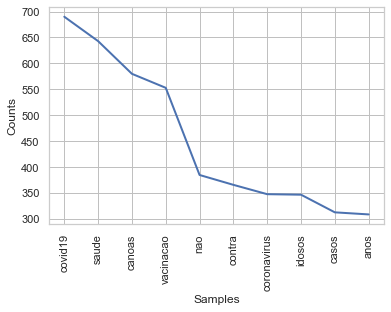

Estado SC 


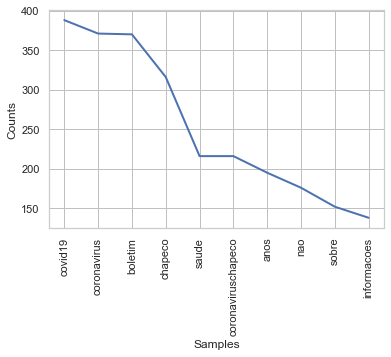

Estado SP 


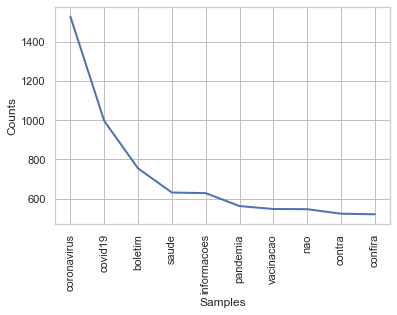

In [146]:
for estado, texto in df_estados.items():
    print("Estado {} ".format(estado))
    freqDist = FreqDist(texto.split(" "))
    freqDist.plot(10)

Estado ES 


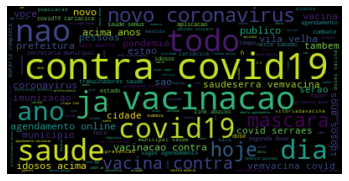

Estado MG 


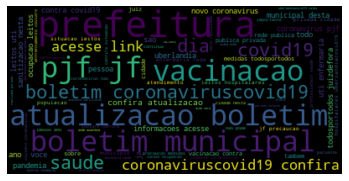

Estado MT 


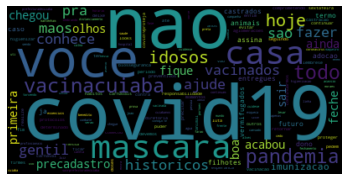

Estado PB 


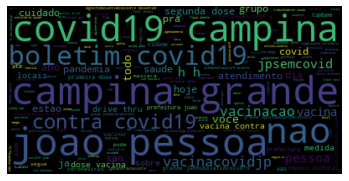

Estado PE 


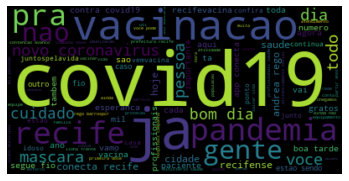

Estado PR 


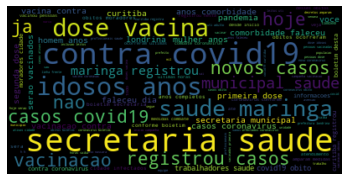

Estado RJ 


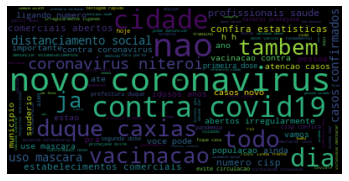

Estado RS 


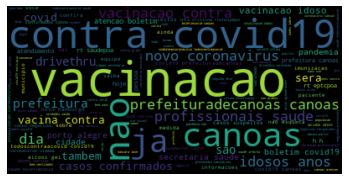

Estado SC 


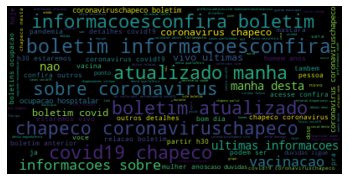

Estado SP 


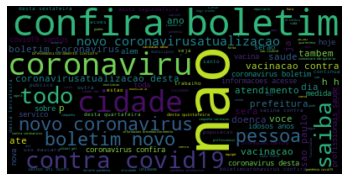

In [147]:
for estados, texto in df_estados.items():
    print("Estado {} ".format(estados))
    # Cria a imagem da nuvem de palavras:
    wordcloud = WordCloud().generate(texto)

    # Exibe a imagem gerada
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Estado ES 


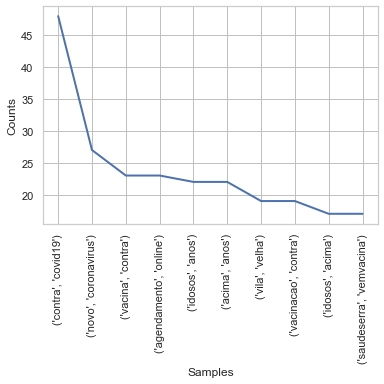

Estado MG 


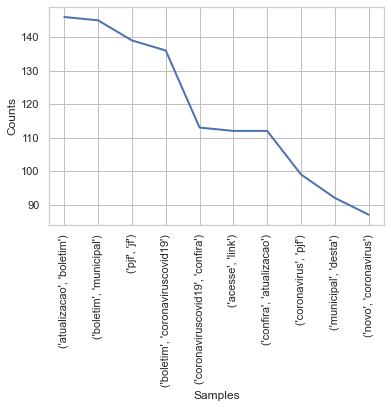

Estado MT 


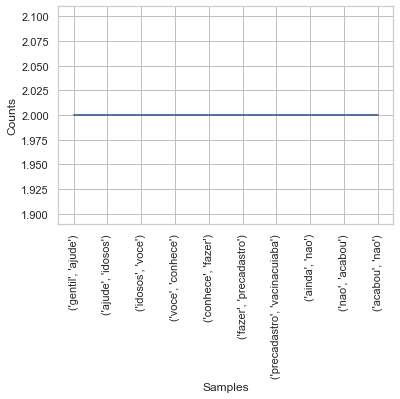

Estado PB 


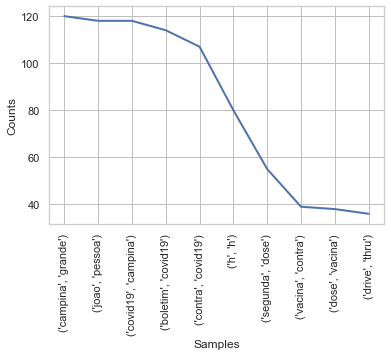

Estado PE 


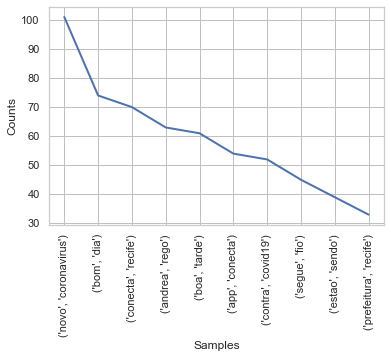

Estado PR 


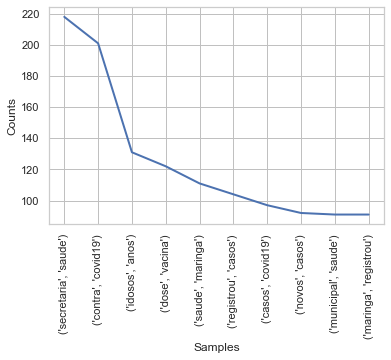

Estado RJ 


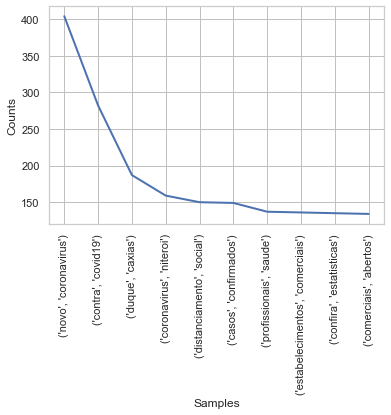

Estado RS 


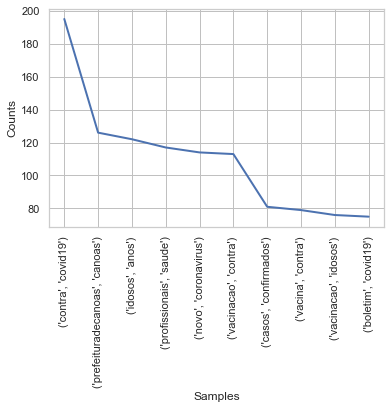

Estado SC 


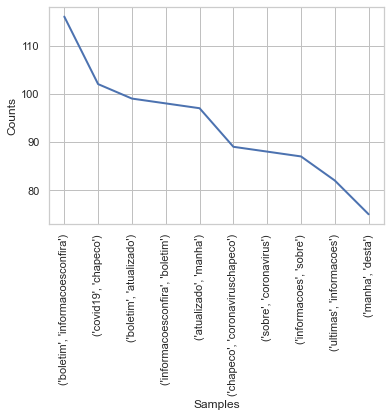

Estado SP 


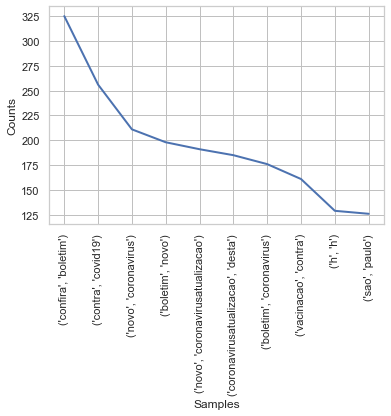

In [148]:
for estado, texto in df_estados.items():
    print("Estado {} ".format(estado))
    freqDist = FreqDist(nltk.bigrams(texto.split(" ")))
    freqDist.plot(10)

### Como podemos observar MT pode ser considerado um outlier pois tem muito pouco tweet comparado com os outros estados e na analise de frequencia de palavras e bigramas podemos ver que os dados deste estado divergem muito da maioria. Por este motivo decido remover MT da analise. 

In [149]:
### Removendo MT

df_twitter_covid = df_twitter_covid[df_twitter_covid['estado'] != 'MT']
df_merge_tt = df_merge_tt[df_merge_tt['estado'] != 'MT']

### Agora com os tweets somente sobre a pandemia analiso o grafico de tweets por cidade e estados novamente

In [150]:
df_municipio_c = df_twitter_covid.groupby(['municipio']).size().reset_index(name="Count_c").sort_values('Count_c', ascending=False)
df_municipio = df_merge_tt.groupby(['municipio']).size().reset_index(name="Count").sort_values('Count', ascending=False)

total_mais = df.groupby(["municipio", "populacao"])["confirmados", "obitos"].sum().reset_index()
total_mais["confirmados_100k"] = total_mais['confirmados']/total_mais['populacao'] * 100000
total_mais["obitos_100k"] = (total_mais['obitos']/total_mais['populacao']) * 100000
total_mais = total_mais[["municipio", "confirmados_100k", "obitos_100k"]]

total_mais

,municipio,confirmados_100k,obitos_100k
0,Alvorada,5493.678792,269.692267
1,Ananindeua,1935.591087,110.541185
2,Anápolis,5412.331662,180.717356
3,Aracaju,13177.311748,216.270522
4,Araçatuba,7226.604889,245.294732
...,...,...,...
94,Viamão,1682.390305,189.620058
95,Vila Velha,8603.002045,208.647085
96,Vitória,9379.125610,245.452433
97,Volta Redonda,5495.861133,228.112180


Text(0.5, 1.0, 'Ranking de cidades com MAIS tweets sobre COVID 19 por municipio - % ')

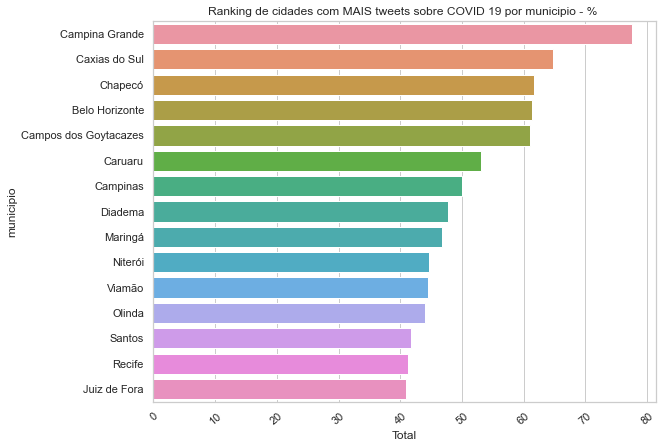

In [151]:
df_municipio_c = df_twitter_covid.groupby(['municipio']).size().reset_index(name="Count_c").sort_values('Count_c', ascending=False)
df_municipio = df_merge_tt.groupby(['municipio']).size().reset_index(name="Count").sort_values('Count', ascending=False)


df_mun_merge = pd.merge(df_municipio, df_municipio_c, left_on='municipio', right_on='municipio')
df_mun_merge['percent_tweets_covid'] = (100*df_mun_merge['Count_c']) / df_mun_merge['Count']


f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="percent_tweets_covid", y="municipio", order=df_mun_merge.sort_values('percent_tweets_covid', ascending=False)["municipio"].head(15), data=df_mun_merge, orient='h')
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.title("Ranking de cidades com MAIS tweets sobre COVID 19 por municipio - % ")

Text(0.5, 1.0, 'Ranking de cidades com MENOS tweets sobre COVID 19 por municipio - % ')

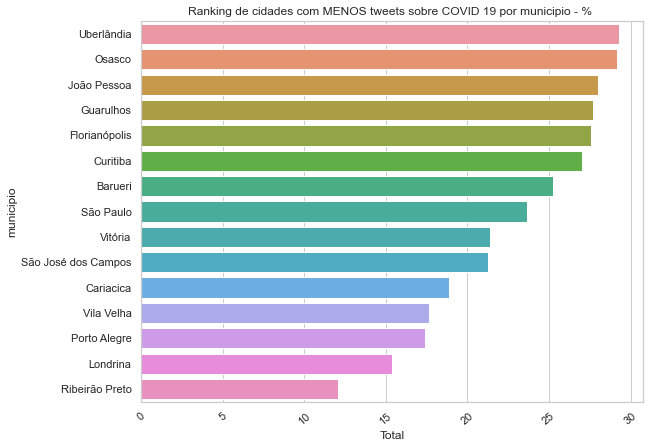

In [152]:
f, ax = plt.subplots(figsize=(9,7))
ax = sns.barplot(x="percent_tweets_covid", y="municipio", order=df_mun_merge.sort_values('percent_tweets_covid', ascending=False)["municipio"].tail(15), data=df_mun_merge, orient='h')
plt.xticks(rotation=40)
plt.xlabel("Total")
plt.xlabel("Total")
plt.title("Ranking de cidades com MENOS tweets sobre COVID 19 por municipio - % ")

Text(0.5, 1.0, 'Ranking de estados que mais tweetam sobre COVID %')

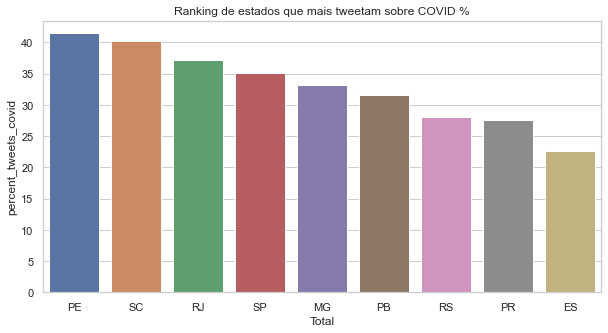

In [153]:
df_est_c = df_twitter_covid.groupby('estado').size().reset_index(name="Count_c")
df_est = df_merge_tt.groupby(['estado']).size().reset_index(name="Count")


## Adicionado o estado no df do twitter tambem. 
df_est_merge = pd.merge(df_est_c, df_est, left_on='estado', right_on='estado')
df_est_merge['percent_tweets_covid'] = (100*df_est_merge['Count_c']) / df_est_merge['Count']

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x="estado", y="percent_tweets_covid", order=df_est_merge.sort_values('percent_tweets_covid', ascending=False)["estado"], data=df_est_merge)
plt.xlabel("Total")
plt.title("Ranking de estados que mais tweetam sobre COVID %")

### Comparando as taxas de covid dos municipios que mais twittam com os que menos twittam sobre covid

In [154]:
## Menos se comunicam a respeito do covid
df_mun_merg = df_mun_merge.sort_values('percent_tweets_covid', ascending=False).tail(15)
list_mun_menos_covid = df_mun_merg['municipio']
df_men_c = df[df['municipio'].isin(list_mun_menos_covid)]

## Mais se comunicam a respeito do covid
df_mun_merg = df_mun_merge.sort_values('percent_tweets_covid', ascending=False).head(15)
list_mun_mais_covid = df_mun_merg['municipio']
df_mais_c = df[df['municipio'].isin(list_mun_mais_covid)]

total_mais = df.groupby(["municipio", "populacao"])["confirmados", "obitos"].sum().reset_index()
total_mais = total_mais[total_mais['municipio'].isin(list_mun_mais_covid)]
total_mais["confirmados_100k"] = total_mais['confirmados']/total_mais['populacao'] * 100000
total_mais["obitos_100k"] = (total_mais['obitos']/total_mais['populacao']) * 100000
total_mais = total_mais[["municipio", "confirmados_100k", "obitos_100k"]]
total_mais["tweets"] = "mais_tweets"

total_menos = df.groupby(["municipio", "populacao"])["confirmados", "obitos"].sum().reset_index()
total_menos = total_menos[total_menos['municipio'].isin(list_mun_menos_covid)]
total_menos["confirmados_100k"] = total_menos['confirmados']/total_menos['populacao'] * 100000
total_menos["obitos_100k"] = (total_menos['obitos']/total_menos['populacao']) * 100000
total_menos = total_menos[["municipio", "confirmados_100k", "obitos_100k"]]
total_menos["tweets"] = "menos_tweets"

frames = [total_mais, total_menos]
result = pd.concat(frames)

result.head()

,municipio,confirmados_100k,obitos_100k,tweets
6,Belo Horizonte,4510.573596,100.929423,mais_tweets
14,Campina Grande,4694.189268,165.125896,mais_tweets
15,Campinas,5407.433893,202.917798,mais_tweets
19,Campos dos Goytacazes,2851.508702,166.872731,mais_tweets
23,Caruaru,3394.127213,134.144405,mais_tweets


Text(0.5, 1.0, 'Comparação de casos confirmados de COVID X Cidade que mais e menos twittam')

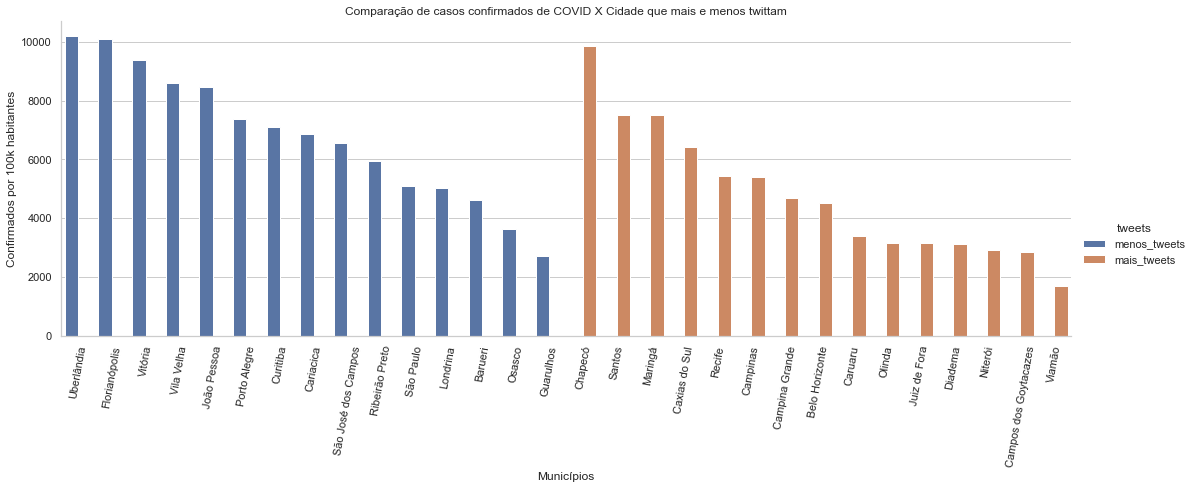

In [155]:
result = result.sort_values(["tweets", 'confirmados_100k'], ascending=False)

sns.factorplot(y='confirmados_100k', x='municipio', hue='tweets', data=result, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Confirmados por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação de casos confirmados de COVID X Cidade que mais e menos twittam")

Text(0.5, 1.0, 'Comparação de óbitos de COVID X Cidade que mais e menos twittam')

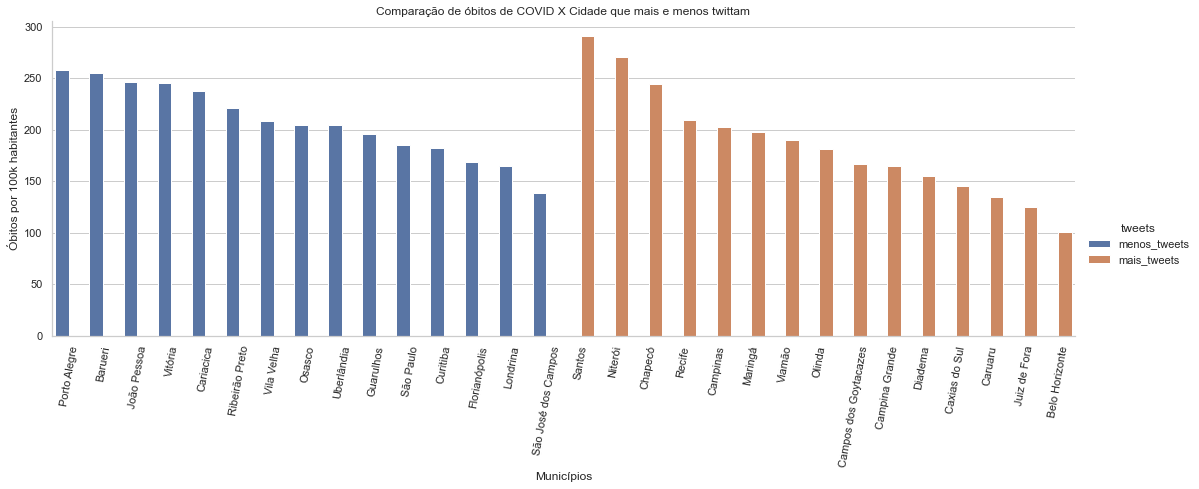

In [156]:
result = result.sort_values(["tweets", 'obitos_100k'], ascending=False)

sns.factorplot(y='obitos_100k', x='municipio', hue='tweets', data=result, kind='bar', ax=ax, height=5, aspect=3)
plt.xlabel("Municípios")
plt.ylabel("Óbitos por 100k habitantes")
plt.xticks(rotation=80)
plt.title("Comparação de óbitos de COVID X Cidade que mais e menos twittam")

## Algumas observações importantes:

1. Seria ineterssante analisar isto com um timeseries para saber que por exemplo em janeiro nao houve tweets e houve uma maior contaminação ja no mês seguinte pode ter tido mais tweets e com isso a contaminação pode ter caido. 

2.  numero de habitantes tambem é uma métrica muito interessante pois temos cidades com poucos habitantes em geral o que as diferencia de cidades com uma população muito grade. 

In [165]:
df_municipio_c = df_twitter_covid.groupby(['municipio']).size().reset_index(name="Count_c").sort_values('Count_c', ascending=False)
df_municipio = df_merge_tt.groupby(['estado', 'municipio']).size().reset_index(name="Count").sort_values('Count', ascending=False)

list_mun_tweets = df_municipio[['estado','municipio']]

total_mun = df.groupby(['estado',"municipio", "populacao"])["confirmados", "obitos"].sum().reset_index()
total_mun = total_mun[total_mun['municipio'].isin(list_mun_tweets['municipio'])]
total_mun = total_mun[total_mun.set_index(['estado','municipio']).index.isin(list_mun_tweets.set_index(['estado','municipio']).index)]
total_mun["confirmados_100k"] = total_mun['confirmados']/total_mun['populacao'] * 100000
total_mun["obitos_100k"] = (total_mun['obitos']/total_mun['populacao']) * 100000
total_mun = total_mun[["estado", "municipio", "populacao", "confirmados","obitos", "confirmados_100k", "obitos_100k"]]

total_mun_merge = pd.merge(total_mun, df_municipio, left_on='municipio', right_on='municipio').merge(df_municipio_c,on='municipio')

In [166]:
## Salvando para responder a hipotese
total_mun_merge.to_csv('datasets/PrefsTweetsPorConfirmados.csv', sep=';', encoding='utf-8')

In [171]:
df_merge_tt.groupby("municipio").size()

municipio
Barueri                     392
Belo Horizonte              189
Campina Grande              209
Campinas                   1498
Campos dos Goytacazes       390
Canoas                     3225
Cariacica                   530
Caruaru                      32
Caxias do Sul                71
Chapecó                     849
Curitiba                   2658
Diadema                     429
Duque de Caxias            1328
Florianópolis              1214
Guarulhos                   213
Jaboatão dos Guararapes       1
Joinville                   309
João Pessoa                2638
Juiz de Fora                806
Jundiaí                    1472
Londrina                   1849
Maringá                    1247
Mogi das Cruzes             554
Niterói                    3250
Nova Iguaçu                 182
Novo Hamburgo               441
Olinda                       84
Osasco                       24
Pelotas                      13
Porto Alegre               3250
Recife                     274

In [175]:
group_engage = df_twitter_covid.groupby("municipio").sum().reset_index().sort_values(['like_count', 'retweet_count'], ascending=False)

total_mun_merge_eng = pd.merge(group_engage, total_mun_merge, left_on='municipio', right_on='municipio')
total_mun_merge_eng.drop('referenced_twitter', axis=1, inplace=True)
total_mun_merge_eng.drop('quote_count', axis=1, inplace=True)
total_mun_merge_eng.drop('text_len', axis=1, inplace=True)
total_mun_merge_eng.drop('estado_y', axis=1, inplace=True)

## Salvando para responder a hipotese
total_mun_merge_eng.to_csv('datasets/PrefsTweetsPorConfirmadosEng.csv', sep=';', encoding='utf-8')

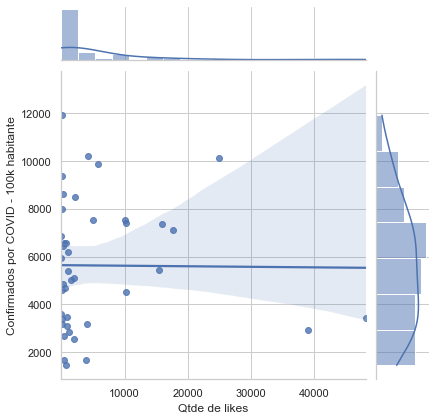

In [181]:
g = sns.jointplot(x="like_count", y="confirmados_100k", data=total_mun_merge_eng,
                  kind="reg")

g.set_axis_labels("Qtde de likes", "Confirmados por COVID - 100k habitante")

In [ ]:
## Percebo que ha alguns municipios que possuem muitos likes, então decido tirar uma media de likes por municipio para deixar um pouco mais igual
